In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../")
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pickle
import glob
from tqdm.notebook import trange, tqdm
import json
import re
import pandas as pd
import numpy as np
from collections import defaultdict

from utills import chunker, cartesian_product, get_num_chunks
from train_utils import generate_unique_pairs, get_random_author_excluding, generate_doc_pairs, fit_transformers, vectorize


from sklearn.linear_model import SGDClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc

from sklearn.utils.fixes import loguniform
from sklearn.model_selection import RandomizedSearchCV

In [3]:

from plotly.offline import init_notebook_mode
import plotly.offline as py
import plotly.graph_objs as go
init_notebook_mode(connected=True)

In [4]:
COMPUTED_DATA_PATH = '../temp_data/reddit/preprocessed/'
chunk_sz=40
TEMP_DATA = '../temp_data/reddit/multidoc_' + str(chunk_sz) + '/'

In [5]:
with open(COMPUTED_DATA_PATH + 'metadata.p', 'rb') as f:
    (train_files, test_files, min_count, author_mapping) = pickle.load(f)

Vectorize Data
===

In [6]:
transformer, scaler, secondary_scaler = fit_transformers(
    COMPUTED_DATA_PATH + 'train.jsonl', 
    author_mapping, 
    chunk_sz, 
    sample_fraction=0.1
)

Sampled: 10079
Reading preprocessed data...



Fitting transformer
Generating pairs


In [7]:
with open(TEMP_DATA + 'model_' + str(chunk_sz) + '.p', 'wb') as f:
    pickle.dump((transformer, scaler, secondary_scaler ), f)

In [8]:
XX_train, author_bounds, author_subreddit, x_shape = vectorize(
    preprocessed_path = COMPUTED_DATA_PATH + 'train.jsonl', 
    vectorized_x_path = TEMP_DATA + 'XX_train_' + str(chunk_sz) + '.npy', 
    transformer=transformer,
    scaler=scaler,
    chunk_sz=chunk_sz
)

Precomputing record size...


In [9]:
XX_test, author_bounds_test, author_subreddit_test, x_shape_test = vectorize(
    preprocessed_path = COMPUTED_DATA_PATH + 'test.jsonl', 
    vectorized_x_path = TEMP_DATA + 'XX_test_' + str(chunk_sz) + '.npy', 
    transformer=transformer,
    scaler=scaler,
    chunk_sz=chunk_sz
)

Precomputing record size...


In [10]:
with open(TEMP_DATA + 'experiment_data' + str(chunk_sz) + '.p', 'wb') as f:
    pickle.dump((author_bounds, author_bounds_test, author_subreddit, author_subreddit_test, x_shape, x_shape_test), f)

Train the classifier
===

In [11]:
author_mapping = defaultdict(set)
author_to_root = {}
for y in author_bounds.keys():
    u = re.search(r'(.*)_[A-Z]+$', y).group(1)
    author_mapping[u].add(y)
    author_to_root[y] = u

subreddit_to_author = defaultdict(list)
for k, v in author_subreddit.items():
    subreddit_to_author[v].append(k)

    
author_mapping_test = defaultdict(set)
author_to_root_test = {}
for y in author_bounds_test.keys():
    u = re.search(r'(.*)_[A-Z]+$', y).group(1)
    author_mapping_test[u].add(y)
    author_to_root_test[y] = u

subreddit_to_author_test = defaultdict(list)
for k, v in author_subreddit_test.items():
    subreddit_to_author_test[v].append(k)

X_idxs_train, Y_train = generate_doc_pairs(author_mapping, subreddit_to_author, author_to_root, author_bounds, author_subreddit)
X_idxs_test, Y_test = generate_doc_pairs(author_mapping_test, subreddit_to_author_test, author_to_root_test, author_bounds_test, author_subreddit_test)




In [12]:
len(Y_train), Y_train.mean()

(2260731, 0.5000002211674012)

In [13]:
with open(TEMP_DATA + 'experiment_data' + str(chunk_sz) + '.p', 'wb') as f:
    pickle.dump((
        author_bounds, 
        author_bounds_test, 
        author_subreddit, 
        author_subreddit_test, 
        x_shape, 
        x_shape_test,
        X_idxs_train,
        Y_train,
        X_idxs_test,
        Y_test
    ), f)

In [15]:
batch_sz = 10000
x_test_diff_sample = secondary_scaler.transform(np.abs(XX_test[X_idxs_test[:batch_sz, 0]] - XX_test[X_idxs_test[:batch_sz, 1]]))
y_test_sample = Y_test[:batch_sz]

In [ ]:
batch_sz = 10000
clf = SGDClassifier(loss='log', alpha=0.01)

aucs = []
for i in range(100):
    for idxs in chunker(np.arange(len(X_idxs_train)), batch_sz):
        x_diff = secondary_scaler.transform(np.abs(XX_train[X_idxs_train[idxs, 0]] - XX_train[X_idxs_train[idxs, 1]]))
        x_diff[np.isnan(x_diff)]=0
        y = Y_train[idxs]
        clf.partial_fit(x_diff, y, classes=[0, 1])

        probs = clf.predict_proba(x_test_diff_sample)[:, 1]

        fpr, tpr, thresh = roc_curve(y_test_sample, probs)
        roc_auc = auc(fpr, tpr)
        print('AUC:', roc_auc)
    print('~'*20, 'Epoch: ', i)
    aucs.append(roc_auc)

AUC: 0.7950212079026462
AUC: 0.8221123990240113
AUC: 0.833051191967769
AUC: 0.8295165748602225
AUC: 0.8449935697688776
AUC: 0.8342174576124949
AUC: 0.8451417304859756
AUC: 0.8502869153886705
AUC: 0.8503623957539954
AUC: 0.8521941046194663
AUC: 0.8541551741110427
AUC: 0.8621896129977269
AUC: 0.8678628004559541
AUC: 0.8683449027893295
AUC: 0.863884881202825
AUC: 0.8661337320872633
AUC: 0.862547134728132
AUC: 0.8682784824678552
AUC: 0.8751276556178531
AUC: 0.8666530746008811
AUC: 0.8734452274749009
AUC: 0.8802564604412686
AUC: 0.8745259527056112
AUC: 0.8767886436570353
AUC: 0.8706864941226315
AUC: 0.8799656590337898
AUC: 0.8827227123779279
AUC: 0.8810101440890974
AUC: 0.8783452111908221
AUC: 0.8770781450582221
AUC: 0.8836173767081033
AUC: 0.8849604432085451
AUC: 0.885243624579143
AUC: 0.8797646980611387
AUC: 0.8787482731416421
AUC: 0.882223029959465
AUC: 0.8844178005821548
AUC: 0.8869686729283769
AUC: 0.8879469176630814
AUC: 0.8843958004756742
AUC: 0.8870324132368801
AUC: 0.88580600730107

AUC: 0.9189344476427266
AUC: 0.9192900093636454
AUC: 0.919203248943725
AUC: 0.9188839273982086
AUC: 0.9178312823034063
AUC: 0.9182779244651544
AUC: 0.9193830898141547
AUC: 0.919312489472449
AUC: 0.9191316085969856
AUC: 0.9193450496300402
AUC: 0.9189677278038025
AUC: 0.9176151212571869
AUC: 0.9184770454288997
AUC: 0.9182762044568296
AUC: 0.9180194832142987
AUC: 0.9184205651555353
AUC: 0.9179043226569217
AUC: 0.9184111651100392
AUC: 0.9180588434048023
AUC: 0.9189854478895678
AUC: 0.9190227280700038
AUC: 0.9187568067829449
AUC: 0.9193897698464861
AUC: 0.9190678082881922
AUC: 0.9190723683102625
AUC: 0.9191406486407395
AUC: 0.9199216524207977
AUC: 0.9198356920047494
AUC: 0.9200614930976265
AUC: 0.920073173154158
AUC: 0.9197894117807531
AUC: 0.9199989727950284
AUC: 0.9198374120130741
AUC: 0.9201646135967297
AUC: 0.9201019732935509
AUC: 0.9201357734571435
AUC: 0.919567890708591
AUC: 0.9194099699442545
AUC: 0.9206315358566336
AUC: 0.9202026137806507
AUC: 0.9204434149461284
AUC: 0.9202636540760

AUC: 0.9212076186448741
AUC: 0.9215479402920311
AUC: 0.921213138671591
AUC: 0.9213760594601278
AUC: 0.921381939488587
AUC: 0.9216750609072949
AUC: 0.9208573369495109
AUC: 0.9212003386096388
AUC: 0.9214126196370791
AUC: 0.9218483417459741
AUC: 0.9217786614087211
AUC: 0.9211735784801198
AUC: 0.9214859799921433
AUC: 0.9215656203776026
AUC: 0.9212300587534845
AUC: 0.921178778505288
AUC: 0.9212785789883222
AUC: 0.9212419388109838
AUC: 0.9216394207347963
AUC: 0.9213926595404721
AUC: 0.9213283792293556
AUC: 0.92073413635322
AUC: 0.920725816312951
AUC: 0.9210739379978599
AUC: 0.9215713004050939
AUC: 0.9205038152384656
AUC: 0.9200555730689736
AUC: 0.9204821751337277
AUC: 0.9209908575957506
AUC: 0.9216714208896771
AUC: 0.9212219387141833
AUC: 0.920836376848064
AUC: 0.9212974190795082
AUC: 0.921316299170888
AUC: 0.9218995019935896
AUC: 0.9218011015173313
AUC: 0.9217621813289576
AUC: 0.9214813799698791
AUC: 0.9220437826919081
AUC: 0.921669540880578
AUC: 0.9216488607804862
AUC: 0.9219521422483684
A

AUC: 0.9217847014379548
AUC: 0.9215533403181672
AUC: 0.9217749013905228
AUC: 0.9218529417682381
AUC: 0.9216129806068262
AUC: 0.9216366207212443
AUC: 0.9217733013827788
AUC: 0.9216551008106879
AUC: 0.9211942185800179
AUC: 0.9216736609005189
AUC: 0.9216660608637346
AUC: 0.9215151801334718
AUC: 0.92148950000918
AUC: 0.9212384587941406
AUC: 0.9214550598424898
AUC: 0.921480379965039
AUC: 0.9218506217570094
AUC: 0.9219822223939564
AUC: 0.9217054210542378
AUC: 0.9219124220561228
AUC: 0.9219035820133369
AUC: 0.9219841824034428
AUC: 0.9220537827403086
AUC: 0.9221893033962284
AUC: 0.922195463426043
AUC: 0.9222649437623278
AUC: 0.922177623339697
AUC: 0.9221101830132858
AUC: 0.9222651037631021
AUC: 0.9223878643572634
AUC: 0.9225559851709683
AUC: 0.9225268250298331
AUC: 0.9224323845727413
AUC: 0.922354544195994
AUC: 0.9224061044455455
AUC: 0.9228993068326451
AUC: 0.9227039858872916
AUC: 0.9223690242660775
AUC: 0.9224605847092301
AUC: 0.9226225854933138
AUC: 0.9225649052141413
AUC: 0.922578745281127

AUC: 0.9227060258971654
AUC: 0.9225118649574262
AUC: 0.9226875858079154
AUC: 0.9222447036643655
AUC: 0.922361144227938
AUC: 0.9224624647183293
AUC: 0.9227269859986122
AUC: 0.9226989858630916
AUC: 0.9223515041812803
AUC: 0.9224543846792219
AUC: 0.9224484246503755
AUC: 0.9225092649448423
AUC: 0.9224871048375873
AUC: 0.9223123839919386
AUC: 0.922561905199621
AUC: 0.9228235864661585
AUC: 0.9227586261517505
AUC: 0.9227449460855391
AUC: 0.9223626642352949
AUC: 0.9223660242515573
AUC: 0.9223790643146713
AUC: 0.9226581856656186
AUC: 0.9220744228402066
AUC: 0.9219547822611462
AUC: 0.9221949034233325
AUC: 0.9224547046807707
AUC: 0.922656745658649
AUC: 0.9220574227579262
AUC: 0.9221201430614925
AUC: 0.9223507041774083
AUC: 0.9223910643727515
AUC: 0.9226270655149971
AUC: 0.9227193059614408
AUC: 0.9227305460158427
AUC: 0.9223855043458411
AUC: 0.9228309465017809
AUC: 0.9228090663958814
AUC: 0.9226137454505281
AUC: 0.9227055858950357
AUC: 0.9228473065809639
AUC: 0.923100387805877
AUC: 0.9227124659283

AUC: 0.9224631847218141
AUC: 0.9224672247413677
AUC: 0.9223110639855497
AUC: 0.9223207840325947
AUC: 0.9224076644530961
AUC: 0.9223983044077935
AUC: 0.9221633432705815
AUC: 0.9224221845233731
AUC: 0.9225156249756249
AUC: 0.9224165444960754
AUC: 0.9223770243047976
AUC: 0.9223995044136014
AUC: 0.9225193449936296
AUC: 0.9224603447080684
AUC: 0.9225635052073652
AUC: 0.9226684257151805
AUC: 0.9224416646176569
AUC: 0.9226039454030959
AUC: 0.9225394250908174
AUC: 0.9226184254731793
AUC: 0.9226550256503241
AUC: 0.9227175859531161
AUC: 0.9226403455792727
AUC: 0.9227242259852538
AUC: 0.9228217064570593
AUC: 0.9226863858021074
AUC: 0.9227175059527288
AUC: 0.9227578661480721
AUC: 0.9228920667976034
AUC: 0.9228906267906336
AUC: 0.9228477465830933
AUC: 0.9227961863335418
AUC: 0.922769306203442
AUC: 0.9230755076854573
AUC: 0.9230024273317483
AUC: 0.9228967468202546
AUC: 0.92298922726786
AUC: 0.9229845872454022
AUC: 0.9229991073156794
AUC: 0.9230032273356202
AUC: 0.9229310269861706
AUC: 0.922920106933

AUC: 0.9229271069671977
AUC: 0.922589985335529
AUC: 0.9226422655885654
AUC: 0.9227582261498146
AUC: 0.9229203869346728
AUC: 0.9229179869230566
AUC: 0.9226784657637743
AUC: 0.9227535061269697
AUC: 0.922728906007905
AUC: 0.9227005058704484
AUC: 0.9225577451794866
AUC: 0.9225179849870474
AUC: 0.9225873853229449
AUC: 0.9228492265902566
AUC: 0.9228029463662604
AUC: 0.9228172664355695
AUC: 0.9225363050757164
AUC: 0.9225423051047568
AUC: 0.92270174587645
AUC: 0.9228702266918972
AUC: 0.9224634647231692
AUC: 0.9222174235323298
AUC: 0.9223980244064381
AUC: 0.9227167859492439
AUC: 0.9230133873847949
AUC: 0.9226909458241778
AUC: 0.9224951448765012
AUC: 0.9225934653523723
AUC: 0.9226673057097596
AUC: 0.9228795067368125
AUC: 0.9229937472897369
AUC: 0.9230768276918462
AUC: 0.9228986268293538
AUC: 0.9231583080862112
AUC: 0.9231327479625001
AUC: 0.9229757472026164
AUC: 0.9229491870740656
AUC: 0.9230873877429566
AUC: 0.9232809886799853
AUC: 0.9230274274527488
AUC: 0.9231541480660768
AUC: 0.9230120673784

AUC: 0.9226030253986431
AUC: 0.922628585522354
AUC: 0.9226827457844895
AUC: 0.9227287860073242
AUC: 0.9225445851157921
AUC: 0.9227157859444041
AUC: 0.9227677861960852
AUC: 0.9227079059062646
AUC: 0.9226971458541858
AUC: 0.9225973453711516
AUC: 0.9226709057271838
AUC: 0.9226114654394927
AUC: 0.9227873862909497
AUC: 0.922875666718227
AUC: 0.9227225459771224
AUC: 0.9228583466343977
AUC: 0.9228024263637435
AUC: 0.9228769067242285
AUC: 0.922929186977265
AUC: 0.9229494670754206
AUC: 0.9229212269387383
AUC: 0.9229553871040737
AUC: 0.922973387191194
AUC: 0.9228944668092194
AUC: 0.9229062668663317
AUC: 0.922964867149957
AUC: 0.9230544275834295
AUC: 0.9230354274914692
AUC: 0.9229981873112267
AUC: 0.9229365870130811
AUC: 0.9229658271546032
AUC: 0.9231902682408984
AUC: 0.923134467970825
AUC: 0.9230815077144974
AUC: 0.9231139078713141
AUC: 0.9231245079226184
AUC: 0.923083227722822
AUC: 0.9231466280296796
AUC: 0.9230693476556426
AUC: 0.9230838277257261
AUC: 0.923050867566199
AUC: 0.9228358665255939


AUC: 0.9228459465743813
AUC: 0.9229250269571305
AUC: 0.9230858677355999
AUC: 0.9230676276473178
AUC: 0.9228967068200611
AUC: 0.9228977468250945
AUC: 0.9228628266560811
AUC: 0.9228475065819319
AUC: 0.9228697066893804
AUC: 0.922845586572639
AUC: 0.9228839867584959
AUC: 0.9231145478744117
AUC: 0.9231170678866085
AUC: 0.9231436280151596
AUC: 0.922956547109688
AUC: 0.9229368270142426
AUC: 0.9229120668944037
AUC: 0.9230043073408475
AUC: 0.9227275060011288
AUC: 0.9226241055006708
AUC: 0.9227279860034522
AUC: 0.9230021473303931
AUC: 0.923141988007222
AUC: 0.9228712266967372
AUC: 0.9227830662700409
AUC: 0.9228272664839696
AUC: 0.9228459065741877
AUC: 0.9230212674229343
AUC: 0.9231194278980311
AUC: 0.9232003482896858
AUC: 0.9230832277228221
AUC: 0.9232764286579147
AUC: 0.9232553885560806
AUC: 0.9230918277644463
AUC: 0.9231216279086791
AUC: 0.9232073883237596
AUC: 0.9233532290296285
AUC: 0.9231519880556223
AUC: 0.9232342284536657
AUC: 0.923147788035294
AUC: 0.923158028084856
AUC: 0.92329658875548

AUC: 0.9228404265476645
AUC: 0.9227276660019035
AUC: 0.9228868667724351
AUC: 0.9229081868756244
AUC: 0.9228672666775708
AUC: 0.9228532266096167
AUC: 0.9228071863867822
AUC: 0.9228848267625617
AUC: 0.9228690266860892
AUC: 0.9229464670609004
AUC: 0.9230254274430689
AUC: 0.9228808667433951
AUC: 0.9229832272388198
AUC: 0.9229429870440572
AUC: 0.9229974673077419
AUC: 0.9230620676204072
AUC: 0.9230884277479903
AUC: 0.9230227874302912
AUC: 0.9230593076070489
AUC: 0.9230905077580576
AUC: 0.9230201874177071
AUC: 0.9230470675478069
AUC: 0.9230659076389929
AUC: 0.923148908040715
AUC: 0.9231483480380046
AUC: 0.9231057478318196
AUC: 0.9230495075596166
AUC: 0.9230646676329912
AUC: 0.9232491085256852
AUC: 0.9232286284265616
AUC: 0.9231551480709166
AUC: 0.9231982682796184
AUC: 0.9232181483758382
AUC: 0.9231934682563863
AUC: 0.9232299484329503
AUC: 0.9231273079361704
AUC: 0.9231313079555304
AUC: 0.923101587811685
AUC: 0.9229271469673914
AUC: 0.9230337074831441
AUC: 0.9231147478753796
AUC: 0.92314870803

AUC: 0.923140588000446
AUC: 0.9229957872996104
AUC: 0.9230003073214874
AUC: 0.9229464670609007
AUC: 0.9228996668343874
AUC: 0.9228282264886162
AUC: 0.9228584666349785
AUC: 0.9228708266948011
AUC: 0.9231164678837046
AUC: 0.9231549880701422
AUC: 0.9231538280645278
AUC: 0.92300966736679
AUC: 0.9230159073969918
AUC: 0.9230004673222618
AUC: 0.9230840277266942
AUC: 0.9228365865290789
AUC: 0.9227631061734339
AUC: 0.9228302264982962
AUC: 0.9230697076573852
AUC: 0.9232083883285995
AUC: 0.9229853072488872
AUC: 0.9228813867459119
AUC: 0.9229263469635194
AUC: 0.9229064668672996
AUC: 0.9230459875425795
AUC: 0.9231354679756649
AUC: 0.9232323084443729
AUC: 0.9231305879520457
AUC: 0.9233038287905313
AUC: 0.9232754686532683
AUC: 0.9231545480680126
AUC: 0.9231562680763375
AUC: 0.9232253484106862
AUC: 0.9233557490418254
AUC: 0.9232052283133051
AUC: 0.923286628707283
AUC: 0.9231918282484486
AUC: 0.9231831882066308
AUC: 0.9232993487688481
AUC: 0.9233355889442505
AUC: 0.9232361484629585
AUC: 0.9232483485220

AUC: 0.9229793872202341
AUC: 0.9230011873257465
AUC: 0.9229783472152004
AUC: 0.9229716671828693
AUC: 0.9228711466963501
AUC: 0.9229221069429977
AUC: 0.9228938668063152
AUC: 0.9230158673967983
AUC: 0.9231015078112979
AUC: 0.922980387225074
AUC: 0.9230653076360891
AUC: 0.9230429075276724
AUC: 0.9230941477756752
AUC: 0.9231348679727609
AUC: 0.9231627481077008
AUC: 0.9231219879104214
AUC: 0.9231504680482653
AUC: 0.9232003482896858
AUC: 0.9231408280016075
AUC: 0.9231706681460338
AUC: 0.9231667481270609
AUC: 0.9232352284585057
AUC: 0.9232173083717725
AUC: 0.9231755481696532
AUC: 0.9231478280354876
AUC: 0.9231268679340408
AUC: 0.9232810286801787
AUC: 0.9232721086370057
AUC: 0.9232224283965534
AUC: 0.9232471085160053
AUC: 0.9232645486004152
AUC: 0.923245628508842
AUC: 0.9232767086592697
AUC: 0.9231687081365474
AUC: 0.9231788281855283
AUC: 0.9231541080658828
AUC: 0.923029227461461
AUC: 0.9231116678604726
AUC: 0.923174668165394
AUC: 0.9232024682999465
AUC: 0.9231600680947295
AUC: 0.9231668281274

AUC: 0.9230875877439246
AUC: 0.9230274674529425
AUC: 0.9229879472616649
AUC: 0.9229918272804442
AUC: 0.922981107228559
AUC: 0.9230039073389114
AUC: 0.9232051083127243
AUC: 0.9232263884157199
AUC: 0.9232528685438837
AUC: 0.9231260679301688
AUC: 0.9231174278883509
AUC: 0.9230791877032684
AUC: 0.9231556680734334
AUC: 0.9229419870392173
AUC: 0.9228234264653841
AUC: 0.9228890667830831
AUC: 0.9230639876297002
AUC: 0.9232028683018825
AUC: 0.9230208274208047
AUC: 0.9229530270926511
AUC: 0.9229926672845097
AUC: 0.9229952272969
AUC: 0.9230953477814833
AUC: 0.9231617481028608
AUC: 0.9232541885502726
AUC: 0.9231732281584243
AUC: 0.9232935887409695
AUC: 0.9232960287527793
AUC: 0.9232189483797102
AUC: 0.923202428299753
AUC: 0.9232649086021576
AUC: 0.9233509090183998
AUC: 0.9232259084133967
AUC: 0.9233146688429972
AUC: 0.9232455485084549
AUC: 0.9232203883866796
AUC: 0.9233354689436696
AUC: 0.9233631090774479
AUC: 0.9232601485791192
AUC: 0.9232562685603398
AUC: 0.9232802686765004
AUC: 0.92335678904685

AUC: 0.9230339474843058
AUC: 0.9230327074783041
AUC: 0.9229777472122965
AUC: 0.9230113073747277
AUC: 0.9230027073331035
AUC: 0.92308242771895
AUC: 0.9231451080223229
AUC: 0.9230489075567125
AUC: 0.9231234279173911
AUC: 0.9231008678082002
AUC: 0.9231397079961867
AUC: 0.9231823082023718
AUC: 0.9232059883169835
AUC: 0.9231867082236679
AUC: 0.9231973082749722
AUC: 0.9232007482916217
AUC: 0.9231564680773056
AUC: 0.92317706817701
AUC: 0.9231766681750739
AUC: 0.9232408284856098
AUC: 0.923226268415139
AUC: 0.9231791881872708
AUC: 0.9231550280703358
AUC: 0.9231433080136108
AUC: 0.9232849486991517
AUC: 0.9232653886044809
AUC: 0.9232420684916116
AUC: 0.9232581485694391
AUC: 0.9232688686213242
AUC: 0.9232471485161987
AUC: 0.9232717086350699
AUC: 0.9232061083175642
AUC: 0.9232127883498955
AUC: 0.9231812681973381
AUC: 0.9230779076970733
AUC: 0.9231685881359665
AUC: 0.9232133083524124
AUC: 0.9232712686329402
AUC: 0.9232261084143648
AUC: 0.9232097883353756
AUC: 0.9231333479654041
AUC: 0.92322254839713

AUC: 0.9230378275030852
AUC: 0.9230309874699792
AUC: 0.9230353474910818
AUC: 0.9230569075954327
AUC: 0.9232332684490194
AUC: 0.9232621885889928
AUC: 0.9232839086941182
AUC: 0.9231762681731381
AUC: 0.9231625081065393
AUC: 0.9231312279551432
AUC: 0.9231898282387687
AUC: 0.923010987373179
AUC: 0.9229050668605236
AUC: 0.9229696671731891
AUC: 0.923087747744699
AUC: 0.9232165083679004
AUC: 0.9230653876364763
AUC: 0.9229915872792824
AUC: 0.9230106673716301
AUC: 0.9230024273317483
AUC: 0.9231055478308515
AUC: 0.9231807481948212
AUC: 0.9232780286656588
AUC: 0.9232034683047865
AUC: 0.9233067488046642
AUC: 0.9233013087783346
AUC: 0.9232180683754508
AUC: 0.9232120683464109
AUC: 0.9232548285533702
AUC: 0.9233511090193677
AUC: 0.9232503085314933
AUC: 0.9233405889684506
AUC: 0.9232742286472668
AUC: 0.9232505885328485
AUC: 0.9233387089593514
AUC: 0.9233658290906128
AUC: 0.9232826686881165
AUC: 0.9232906687268367
AUC: 0.9232867487078638
AUC: 0.9233496290122044
AUC: 0.9234115493118986
AUC: 0.92340798929

AUC: 0.9230207474204174
AUC: 0.9230448275369654
AUC: 0.923030507467656
AUC: 0.9231164278835109
AUC: 0.9231736281603602
AUC: 0.9230880277460543
AUC: 0.9231512680521373
AUC: 0.9231336279667594
AUC: 0.9231845882134069
AUC: 0.9232133883527995
AUC: 0.9232409884863843
AUC: 0.9232284284255936
AUC: 0.9232401484823187
AUC: 0.9232519885396244
AUC: 0.9232077483255018
AUC: 0.9232274284207536
AUC: 0.923233108448245
AUC: 0.9232798286743709
AUC: 0.9232607485820231
AUC: 0.9232278284226896
AUC: 0.9232115083437005
AUC: 0.923192908253676
AUC: 0.9233076688091171
AUC: 0.9232989887671055
AUC: 0.9232679486168714
AUC: 0.9232839486943116
AUC: 0.923296548755296
AUC: 0.923270468629068
AUC: 0.9233051887971138
AUC: 0.9232560685593717
AUC: 0.9232628285920903
AUC: 0.9232336284507616
AUC: 0.9231353079748906
AUC: 0.9232124283481531
AUC: 0.923256348560727
AUC: 0.9232879487136718
AUC: 0.9232525485423348
AUC: 0.9232505485326548
AUC: 0.9231748281661682
AUC: 0.9232587485723431
AUC: 0.9232057883160156
AUC: 0.923277508663142

AUC: 0.9230461075431605
AUC: 0.9230673076457692
AUC: 0.9232249084085566
AUC: 0.9232546685525957
AUC: 0.9232774286627548
AUC: 0.9231801481919173
AUC: 0.9231749081665556
AUC: 0.9231528680598815
AUC: 0.9232155083630605
AUC: 0.9230557875900121
AUC: 0.9229793472200405
AUC: 0.9230199474165455
AUC: 0.9231259879297814
AUC: 0.9232217083930685
AUC: 0.9230869477408269
AUC: 0.9230179474068655
AUC: 0.92304054751625
AUC: 0.9230321874757874
AUC: 0.923119947900548
AUC: 0.9231837082091476
AUC: 0.9232651886035129
AUC: 0.9232085483293739
AUC: 0.9232852687007005
AUC: 0.9232859087037981
AUC: 0.9232178283742893
AUC: 0.9232142283568653
AUC: 0.9232540685496918
AUC: 0.9233385889587706
AUC: 0.9232394284788338
AUC: 0.9233197488675846
AUC: 0.9232728686406841
AUC: 0.9232484285223941
AUC: 0.9233317089254712
AUC: 0.9233624290741569
AUC: 0.9232803486768876
AUC: 0.9232944287450351
AUC: 0.9232999887719456
AUC: 0.9233551490389212
AUC: 0.9234075492925384
AUC: 0.9234260693821758
AUC: 0.9234567495306677
AUC: 0.923378589152

AUC: 0.9230717476672586
AUC: 0.9231459880265821
AUC: 0.9232049083117563
AUC: 0.923134867972761
AUC: 0.9231806281942404
AUC: 0.9231777881804947
AUC: 0.9232156283636412
AUC: 0.9232451885067123
AUC: 0.9232622685893799
AUC: 0.923254748552983
AUC: 0.9232583085702135
AUC: 0.923287428711155
AUC: 0.9232513085363332
AUC: 0.9232635085953815
AUC: 0.9232757886548171
AUC: 0.92331358883777
AUC: 0.9233001087725264
AUC: 0.9232635885957687
AUC: 0.9232431484968386
AUC: 0.9232279484232702
AUC: 0.9233175888571301
AUC: 0.9233047887951777
AUC: 0.9232861487049597
AUC: 0.9232964687549087
AUC: 0.9233160688497734
AUC: 0.9232954687500687
AUC: 0.9233089088151187
AUC: 0.9232975487601359
AUC: 0.9233040687916929
AUC: 0.9232794686726283
AUC: 0.923182588203727
AUC: 0.9232559485587909
AUC: 0.9232909487281918
AUC: 0.9233207888726181
AUC: 0.9232887887177373
AUC: 0.9232880687142525
AUC: 0.9232264684161072
AUC: 0.9232915087309022
AUC: 0.9232237484029423
AUC: 0.9232848686987645
AUC: 0.9233320289270202
AUC: 0.923273828645330

AUC: 0.9232227883982959
AUC: 0.923245148506519
AUC: 0.9232712286327467
AUC: 0.9231850682157302
AUC: 0.923183468207986
AUC: 0.923163748112541
AUC: 0.9232170683706108
AUC: 0.923074827682166
AUC: 0.9230168274014448
AUC: 0.9230478675516789
AUC: 0.9231421480079964
AUC: 0.9232204283868735
AUC: 0.9231008278080066
AUC: 0.9230407475172179
AUC: 0.9230471875483877
AUC: 0.9230405475162499
AUC: 0.9231201079013222
AUC: 0.9231720681528098
AUC: 0.9232579085682774
AUC: 0.9232085083291803
AUC: 0.9232781086660461
AUC: 0.9232859087037981
AUC: 0.923231988442824
AUC: 0.9232234284013935
AUC: 0.9232575485665351
AUC: 0.9233369889510264
AUC: 0.9232471085160051
AUC: 0.9233150288447396
AUC: 0.923271788635457
AUC: 0.9232437084995491
AUC: 0.9233213088751351
AUC: 0.9233417889742587
AUC: 0.9232767086592699
AUC: 0.923281508682502
AUC: 0.9232790686706924
AUC: 0.9233359889461865
AUC: 0.9233986692495592
AUC: 0.9234127093175131
AUC: 0.9234412294555506
AUC: 0.9233748691343665
AUC: 0.923264668600996
AUC: 0.9233131888358339


AUC: 0.9232199483845502
AUC: 0.9231530280606558
AUC: 0.9232001082885242
AUC: 0.9231949882637434
AUC: 0.923223468401587
AUC: 0.9232544685516277
AUC: 0.9232638685971241
AUC: 0.923263068593252
AUC: 0.9232689086215178
AUC: 0.9232881887148334
AUC: 0.9232560285591782
AUC: 0.923274788649977
AUC: 0.923278308667014
AUC: 0.9233118688294452
AUC: 0.923297948762072
AUC: 0.9232659886073848
AUC: 0.9232496285282021
AUC: 0.923238708475349
AUC: 0.923316188850354
AUC: 0.92330514879692
AUC: 0.9232904687258686
AUC: 0.9232968287566511
AUC: 0.9233104288224755
AUC: 0.9232996687703968
AUC: 0.9233122288311874
AUC: 0.923304068791693
AUC: 0.9233155888474501
AUC: 0.9232962287537472
AUC: 0.9232167083688684
AUC: 0.9232745086486218
AUC: 0.9233068288050514
AUC: 0.9233311489227607
AUC: 0.9233037487901443
AUC: 0.9232995887700096
AUC: 0.9232471085160052
AUC: 0.9233095488182161
AUC: 0.9232520685400117
AUC: 0.9233076688091171
AUC: 0.9233492290102683
AUC: 0.9233007487756241
AUC: 0.9233599490621535
AUC: 0.9233583090542158
AU

AUC: 0.9232932687394206
AUC: 0.9232179483748703
AUC: 0.9232189483797101
AUC: 0.9231980282784569
AUC: 0.923240908485997
AUC: 0.9231106678556324
AUC: 0.9230581076012407
AUC: 0.9230925077677374
AUC: 0.9231726281555203
AUC: 0.9232259884137839
AUC: 0.9231191478966758
AUC: 0.9230624676223432
AUC: 0.9230701876597083
AUC: 0.9230604276124696
AUC: 0.9231339879685018
AUC: 0.9231864682225063
AUC: 0.9232621085886055
AUC: 0.9232231484000384
AUC: 0.9232867887080574
AUC: 0.9232835486923756
AUC: 0.923232708446309
AUC: 0.9232250284091376
AUC: 0.9232545085518215
AUC: 0.9233252688943014
AUC: 0.9232570285640183
AUC: 0.9233214288757158
AUC: 0.9232783886674011
AUC: 0.9232580685690519
AUC: 0.9233302689185017
AUC: 0.9233523490253692
AUC: 0.9232964687549087
AUC: 0.9232938287421313
AUC: 0.9232955087502623
AUC: 0.9233465889974907
AUC: 0.9234038692747272
AUC: 0.9234106693076395
AUC: 0.9234458294778145
AUC: 0.9233863491899301
AUC: 0.9232850286995389
AUC: 0.9233307489208249
AUC: 0.9233005887748497
AUC: 0.92327146863

AUC: 0.9232064283191129
AUC: 0.9232109883411835
AUC: 0.9232403084830931
AUC: 0.9232671486129992
AUC: 0.9232809486797916
AUC: 0.9232749486507514
AUC: 0.9232830686900524
AUC: 0.9233017087802704
AUC: 0.9232719086360377
AUC: 0.9232813886819212
AUC: 0.9232818686842444
AUC: 0.9233186288621636
AUC: 0.9233013887787217
AUC: 0.9232772686619802
AUC: 0.9232564285611142
AUC: 0.9232513085363332
AUC: 0.9233233888852023
AUC: 0.923309388817442
AUC: 0.9232957887516176
AUC: 0.9232972687587808
AUC: 0.9233085888135699
AUC: 0.9232988687665248
AUC: 0.92331558884745
AUC: 0.9233151488453204
AUC: 0.9233267889016582
AUC: 0.9233059088005986
AUC: 0.9232351084579249
AUC: 0.9232835486923756
AUC: 0.9233125488327363
AUC: 0.9233363889481225
AUC: 0.9233146688429972
AUC: 0.9233255488956567
AUC: 0.9232812286811467
AUC: 0.923326828901852
AUC: 0.9232716286346826
AUC: 0.923319988868746
AUC: 0.9233605490650573
AUC: 0.9233132288360275
AUC: 0.9233663490931295
AUC: 0.9233633490786096
AUC: 0.9233304289192761
AUC: 0.92333778895489

AUC: 0.923232508445341
AUC: 0.9232140683560909
AUC: 0.9232555885570486
AUC: 0.923136667981473
AUC: 0.9230874277431502
AUC: 0.9231274279367512
AUC: 0.9231840682108902
AUC: 0.9232247884079756
AUC: 0.923131667957273
AUC: 0.9230876677443117
AUC: 0.9230840677268879
AUC: 0.9230827077203053
AUC: 0.92314718803239
AUC: 0.9231940682592903
AUC: 0.9232545485520149
AUC: 0.9232195483826142
AUC: 0.9232800686755324
AUC: 0.9232833886916014
AUC: 0.9232424684935475
AUC: 0.92324382850013
AUC: 0.923268388619001
AUC: 0.9233283489092088
AUC: 0.9232663886093209
AUC: 0.923319788867778
AUC: 0.9232871887099934
AUC: 0.9232614285853145
AUC: 0.923323708886751
AUC: 0.9233437489837452
AUC: 0.9232864687065084
AUC: 0.9232812286811468
AUC: 0.923291028728579
AUC: 0.9233329889316665
AUC: 0.9233849491831541
AUC: 0.9234010292609816
AUC: 0.9234304294032781
AUC: 0.9233691091064881
AUC: 0.9232770686610123
AUC: 0.9233301489179208
AUC: 0.9233080688110531
AUC: 0.9232855887022493
AUC: 0.9232974287595552
AUC: 0.9232605485810552
AUC

AUC: 0.9232561085595654
AUC: 0.9232793886722411
AUC: 0.9232944287450351
AUC: 0.9232874287111549
AUC: 0.9232947087463903
AUC: 0.9233093088170548
AUC: 0.9232825886877294
AUC: 0.9232895887216094
AUC: 0.9232916687316768
AUC: 0.9233211088741669
AUC: 0.9233041487920801
AUC: 0.9232828686890845
AUC: 0.9232649086021576
AUC: 0.9232599485781512
AUC: 0.9233272689039816
AUC: 0.9233173088557749
AUC: 0.9232971087580064
AUC: 0.9233033087880145
AUC: 0.9233093488172484
AUC: 0.9233016287798834
AUC: 0.9233135888377699
AUC: 0.9233223088799749
AUC: 0.9233310689223734
AUC: 0.9233152688459012
AUC: 0.9232381884728321
AUC: 0.9232849886993452
AUC: 0.9233193088654549
AUC: 0.9233387489595449
AUC: 0.9233177088577107
AUC: 0.9233273089041751
AUC: 0.9232833086912142
AUC: 0.9233257088964311
AUC: 0.9232768686600442
AUC: 0.9233226688817175
AUC: 0.9233574690501503
AUC: 0.9233155488472565
AUC: 0.9233696691091984
AUC: 0.9233616290702846
AUC: 0.9233330689320536
AUC: 0.9233412289715481
AUC: 0.9233220688788132
AUC: 0.923318028

AUC: 0.9232189483797102
AUC: 0.9232592685748598
AUC: 0.9231559080745951
AUC: 0.9230996678023922
AUC: 0.9231329079632745
AUC: 0.9231903882414791
AUC: 0.9232329084472768
AUC: 0.923143788015934
AUC: 0.9231097878513733
AUC: 0.9231048678275602
AUC: 0.9230934677723841
AUC: 0.9231545080678192
AUC: 0.9231967482722616
AUC: 0.9232592285746662
AUC: 0.9232273084201728
AUC: 0.9232887487175437
AUC: 0.9232920287334191
AUC: 0.9232527485433031
AUC: 0.9232503485316867
AUC: 0.9232668686116441
AUC: 0.9233253488946886
AUC: 0.9232639085973176
AUC: 0.9233114688275093
AUC: 0.923286508706702
AUC: 0.9232629485926711
AUC: 0.923317188855194
AUC: 0.9233397889645785
AUC: 0.9232859887041853
AUC: 0.9232799886751452
AUC: 0.923290228724707
AUC: 0.9233263488995287
AUC: 0.9233722291215889
AUC: 0.9233893892046438
AUC: 0.9234159093330012
AUC: 0.9233634290789967
AUC: 0.9232787086689499
AUC: 0.9233238688875254
AUC: 0.923305068796533
AUC: 0.923284108695086
AUC: 0.9232844686968285
AUC: 0.9232571885647928
AUC: 0.923242508493741

AUC: 0.9232813886819211
AUC: 0.9232567885628565
AUC: 0.9232575085663414
AUC: 0.9232200683851309
AUC: 0.9232226283975214
AUC: 0.9231929482538697
AUC: 0.9231656281216402
AUC: 0.9231518680550413
AUC: 0.9231842682118582
AUC: 0.9231958282678088
AUC: 0.9232283484252064
AUC: 0.9232423484929667
AUC: 0.9232150683609308
AUC: 0.9231787881853348
AUC: 0.923156828079048
AUC: 0.9230985877971648
AUC: 0.9231289879443015
AUC: 0.9231529880604623
AUC: 0.92316262810712
AUC: 0.9231112678585365
AUC: 0.9230881877468287
AUC: 0.9231391479934762
AUC: 0.9231223479121639
AUC: 0.9231839082101158
AUC: 0.9231904682418661
AUC: 0.9231958282678088
AUC: 0.9232363884641202
AUC: 0.9232649486023512
AUC: 0.9232323484445666
AUC: 0.9232439085005171
~~~~~~~~~~~~~~~~~~~~ Epoch:  37
AUC: 0.9232555885570486
AUC: 0.9232724686387481
AUC: 0.9233169488540324
AUC: 0.9232803886770811
AUC: 0.9233026687849168
AUC: 0.9232659486071912
AUC: 0.9232747486497834
AUC: 0.9232601485791191
AUC: 0.9232784686677885
AUC: 0.9232369484668306
AUC: 0.9232

AUC: 0.9233554690404701
AUC: 0.9233443489866491
AUC: 0.9233773491463698
AUC: 0.9233398689649657
AUC: 0.9233090288156993
AUC: 0.9232995087696224
AUC: 0.9232488685245237
AUC: 0.9232390684770915
AUC: 0.9232259084133966
AUC: 0.9232763486575275
AUC: 0.9232849886993452
AUC: 0.9233211888745543
AUC: 0.9232536685477557
AUC: 0.9232830286898587
AUC: 0.9233167488530644
AUC: 0.9233510690191741
AUC: 0.9233267889016582
AUC: 0.9232739086457179
AUC: 0.923352269024982
AUC: 0.9233383489576087
AUC: 0.923370309112296
AUC: 0.9233567090464718
AUC: 0.9233630690772544
AUC: 0.9233689891059073
AUC: 0.9233196288670036
AUC: 0.9233016687800769
AUC: 0.9233462289957483
AUC: 0.923343348981809
AUC: 0.9233340289367001
AUC: 0.9232975887603295
AUC: 0.9233412689717417
AUC: 0.9233311089225671
AUC: 0.9232969887574256
AUC: 0.9233222688797813
AUC: 0.9233141088402868
AUC: 0.9232954687500687
AUC: 0.9232403484832865
AUC: 0.9232437884999364
AUC: 0.9232107483400219
AUC: 0.923169748141581
AUC: 0.9231716681508739
AUC: 0.9231938282581

AUC: 0.9232670286124185
AUC: 0.9232314284401135
AUC: 0.9232329884476641
AUC: 0.9232089483313098
AUC: 0.9231816281990806
AUC: 0.9231684281351921
AUC: 0.923197108274004
AUC: 0.9232041883082713
AUC: 0.9232383884738001
AUC: 0.923245308507293
AUC: 0.9232277084221087
AUC: 0.9231882282310246
AUC: 0.923172868156682
AUC: 0.9231158278806069
AUC: 0.923146588029486
AUC: 0.9231688281371282
AUC: 0.9231764681741059
AUC: 0.9231268279338471
AUC: 0.9231039878233012
AUC: 0.9231489880411021
AUC: 0.923135667976633
AUC: 0.9231941882598712
AUC: 0.9232003482896858
AUC: 0.923202028297817
AUC: 0.9232376684703154
AUC: 0.9232679886170648
AUC: 0.9232360684625714
AUC: 0.9232471085160052
~~~~~~~~~~~~~~~~~~~~ Epoch:  40
AUC: 0.9232610285833782
AUC: 0.923280308676694
AUC: 0.9233183088606147
AUC: 0.9232837486933436
AUC: 0.9233025087841426
AUC: 0.9232707486304235
AUC: 0.9232844686968283
AUC: 0.9232689486217114
AUC: 0.9232818286840508
AUC: 0.9232478685196835
AUC: 0.9232535085469814
AUC: 0.923272988641265
AUC: 0.923313548

AUC: 0.9233723091219762
AUC: 0.9233382689572217
AUC: 0.9233114288273155
AUC: 0.9232980687626529
AUC: 0.9232560285591782
AUC: 0.9232418684906436
AUC: 0.9232299084327569
AUC: 0.9232737886451371
AUC: 0.9232758286550108
AUC: 0.923316188850354
AUC: 0.9232517885386564
AUC: 0.9232728686406843
AUC: 0.9233048687955648
AUC: 0.9233445089874234
AUC: 0.9233218288776517
AUC: 0.9232840286946988
AUC: 0.9233583090542158
AUC: 0.9233426689785178
AUC: 0.9233671890971953
AUC: 0.9233638290809327
AUC: 0.9233671890971952
AUC: 0.9233690291061009
AUC: 0.9233285889103703
AUC: 0.9233115888280898
AUC: 0.9233496290122045
AUC: 0.9233519490234332
AUC: 0.9233426289783243
AUC: 0.9233115088277026
AUC: 0.923344068985294
AUC: 0.9233353089428953
AUC: 0.9233009087763985
AUC: 0.923326428899916
AUC: 0.9233188288631318
AUC: 0.9233019087812386
AUC: 0.9232491085256853
AUC: 0.9232515885376885
AUC: 0.9232160283655774
AUC: 0.9231752281681043
AUC: 0.9231783081830115
AUC: 0.9232050683125308
AUC: 0.9231754681692659
AUC: 0.923143308013

AUC: 0.9232443085024532
AUC: 0.9232195083824206
AUC: 0.9231986682815545
AUC: 0.9231893082362518
AUC: 0.9232135083533805
AUC: 0.9232198283839693
AUC: 0.9232529885444646
AUC: 0.9232573085653735
AUC: 0.9232403084830931
AUC: 0.9232068283210491
AUC: 0.9231899082391558
AUC: 0.9231373079845707
AUC: 0.923161028099376
AUC: 0.9231815481986934
AUC: 0.9231897882385751
AUC: 0.9231429480118684
AUC: 0.923124347921844
AUC: 0.9231611480999568
AUC: 0.9231483080378109
AUC: 0.9232019482974297
AUC: 0.9232099883363436
AUC: 0.9232155883634476
AUC: 0.9232443485026466
AUC: 0.923272188637393
AUC: 0.9232465485132947
AUC: 0.9232538285485302
~~~~~~~~~~~~~~~~~~~~ Epoch:  43
AUC: 0.9232687486207434
AUC: 0.9232860687045725
AUC: 0.9233238688875254
AUC: 0.9232882687152206
AUC: 0.9233059888009857
AUC: 0.9232744286482346
AUC: 0.9232861087047661
AUC: 0.9232756686542363
AUC: 0.9232857487030236
AUC: 0.923253348546207
AUC: 0.9232576285669224
AUC: 0.9232769086602379
AUC: 0.9233140288398997
AUC: 0.9233142288408674
AUC: 0.92327

AUC: 0.9233249488927524
AUC: 0.9233101088209267
AUC: 0.9232685486197753
AUC: 0.9232500285301379
AUC: 0.9232387884757364
AUC: 0.9232840686948924
AUC: 0.9232886687171564
AUC: 0.9233220688788133
AUC: 0.9232533885464005
AUC: 0.9232787886693372
AUC: 0.9233059088005985
AUC: 0.9233448289889723
AUC: 0.9233234688855892
AUC: 0.9232850686997326
AUC: 0.923356389044923
AUC: 0.9233417089738716
AUC: 0.9233658290906127
AUC: 0.9233600290625407
AUC: 0.9233642290828687
AUC: 0.9233695491086177
AUC: 0.9233284689097896
AUC: 0.923311468827509
AUC: 0.9233489090087197
AUC: 0.9233529890284669
AUC: 0.9233442689862618
AUC: 0.9233174688565492
AUC: 0.9233453089912955
AUC: 0.9233386289589641
AUC: 0.9233059088005986
AUC: 0.9233328289308921
AUC: 0.9233202688701013
AUC: 0.9233061088015665
AUC: 0.9232550285543383
AUC: 0.9232578685680839
AUC: 0.9232288284275297
AUC: 0.9231837082091477
AUC: 0.9231853482170853
AUC: 0.9232073883237596
AUC: 0.9231890682350902
AUC: 0.9231470280316156
AUC: 0.9231871082256038
AUC: 0.92319262825

AUC: 0.9232097483351819
AUC: 0.9232004282900729
AUC: 0.9232225083969405
AUC: 0.9232356684606353
AUC: 0.9232587085721495
AUC: 0.9232629485926712
AUC: 0.9232483885222004
AUC: 0.9232193883818398
AUC: 0.9232007882918153
AUC: 0.9231510280509757
AUC: 0.9231745881650066
AUC: 0.9231915082469
AUC: 0.9232022282987848
AUC: 0.9231584680869854
AUC: 0.9231406680008332
AUC: 0.9231743481638451
AUC: 0.9231617081026673
AUC: 0.9232084283287932
AUC: 0.9232125083485403
AUC: 0.9232166683686749
AUC: 0.9232461885115524
AUC: 0.9232757486546235
AUC: 0.923251148535559
AUC: 0.9232592285746664
~~~~~~~~~~~~~~~~~~~~ Epoch:  46
AUC: 0.9232733486430074
AUC: 0.9232901087241261
AUC: 0.9233242288892678
AUC: 0.9232964287547151
AUC: 0.9233101488211203
AUC: 0.9232758286550107
AUC: 0.9232913087299343
AUC: 0.9232804686774683
AUC: 0.9232926287363231
AUC: 0.923261068583572
AUC: 0.9232639885977049
AUC: 0.9232849886993454
AUC: 0.9233199088683589
AUC: 0.9233204288708756
AUC: 0.9232771486613995
AUC: 0.9232616285862824
AUC: 0.923231

AUC: 0.9232641485984792
AUC: 0.9232499085295571
AUC: 0.9232411884873523
AUC: 0.9232847486981837
AUC: 0.9232854687016685
AUC: 0.9233208288728116
AUC: 0.9232643085992536
AUC: 0.9232864287063149
AUC: 0.9233167888532581
AUC: 0.92335146902111
AUC: 0.9233345889394104
AUC: 0.9232919487330318
AUC: 0.9233574690501503
AUC: 0.9233427089787114
AUC: 0.9233644690840304
AUC: 0.9233630290770607
AUC: 0.9233636290799647
AUC: 0.9233689491057135
AUC: 0.9233303089186953
AUC: 0.92331458884261
AUC: 0.9233536290315645
AUC: 0.9233557490418253
AUC: 0.9233467089980716
AUC: 0.9233159488491924
AUC: 0.923338628958964
AUC: 0.9233401889665146
AUC: 0.9233108688246051
AUC: 0.9233355489440569
AUC: 0.9233220288786198
AUC: 0.9233095088180225
AUC: 0.9232586285717623
AUC: 0.9232594285756344
AUC: 0.9232364284643136
AUC: 0.9231923482509656
AUC: 0.9231947882627753
AUC: 0.9232155883634476
AUC: 0.9232067483206619
AUC: 0.9231643081152514
AUC: 0.9231993082846519
AUC: 0.9232039483071098
AUC: 0.9231992682844586
AUC: 0.92320382830652

AUC: 0.9232259484135903
AUC: 0.9232426284943219
AUC: 0.9232615885860888
AUC: 0.9232693886238411
AUC: 0.9232537885483364
AUC: 0.9232253884108799
AUC: 0.92321194834583
AUC: 0.923165228119704
AUC: 0.9231851482161174
AUC: 0.9232007482916216
AUC: 0.9232082683280186
AUC: 0.9231752281681043
AUC: 0.9231539880653021
AUC: 0.923186588223087
AUC: 0.9231699081423553
AUC: 0.9232161883663516
AUC: 0.9232206283878415
AUC: 0.9232249084085566
AUC: 0.9232543885512405
AUC: 0.923279788674177
AUC: 0.9232563485607269
AUC: 0.9232647086011895
~~~~~~~~~~~~~~~~~~~~ Epoch:  49
AUC: 0.923276388657721
AUC: 0.9232905087260622
AUC: 0.9233273889045623
AUC: 0.9232989087667185
AUC: 0.9233122688313811
AUC: 0.9232766286588827
AUC: 0.9232951487485199
AUC: 0.9232799086747578
AUC: 0.9232907887274175
AUC: 0.9232675486149352
AUC: 0.9232680686174521
AUC: 0.9232865887070892
AUC: 0.9233174288563556
AUC: 0.9233200288689397
AUC: 0.923278108666046
AUC: 0.9232635885957688
AUC: 0.9232323484445665
AUC: 0.9232141483564779
AUC: 0.92320286

AUC: 0.9232493885270404
AUC: 0.923292028733419
AUC: 0.9232912687297405
AUC: 0.923319188864874
AUC: 0.9232693086234537
AUC: 0.9232897887225773
AUC: 0.9233173888561621
AUC: 0.9233531490292411
AUC: 0.923332148927601
AUC: 0.9232965087551023
AUC: 0.9233507890178189
AUC: 0.923339748964385
AUC: 0.9233560290431806
AUC: 0.9233579090522797
AUC: 0.9233580290528606
AUC: 0.9233661090919679
AUC: 0.9233310689223735
AUC: 0.9233121088306067
AUC: 0.923346668997878
AUC: 0.9233511090193677
AUC: 0.9233450689901339
AUC: 0.9233179088586787
AUC: 0.9233399889655467
AUC: 0.9233394689630299
AUC: 0.9233166288524837
AUC: 0.9233376689543176
AUC: 0.9233283489092089
AUC: 0.9233163088509349
AUC: 0.9232677486159033
AUC: 0.9232672286133865
AUC: 0.9232477085189092
AUC: 0.9232047483109819
AUC: 0.9232057483158218
AUC: 0.9232248684083632
AUC: 0.9232127883498956
AUC: 0.9231747881659748
AUC: 0.9232047483109819
AUC: 0.9232061483177577
AUC: 0.9232025483003337
AUC: 0.9232096283346011
AUC: 0.9231829882056629
AUC: 0.92319554826645

AUC: 0.9232710686319723
AUC: 0.923278508667982
AUC: 0.9232594685758279
AUC: 0.9232356684606353
AUC: 0.9232210283897773
AUC: 0.9231740681624898
AUC: 0.9231988282823289
AUC: 0.9232126683493147
AUC: 0.9232156283636411
AUC: 0.9231860282203764
AUC: 0.9231646281168002
AUC: 0.9231958282678089
AUC: 0.923178668184754
AUC: 0.9232239884041038
AUC: 0.9232249884089441
AUC: 0.9232338684519233
AUC: 0.9232620285882184
AUC: 0.9232819486846315
AUC: 0.9232613885851209
AUC: 0.923270788630617
~~~~~~~~~~~~~~~~~~~~ Epoch:  52
AUC: 0.923280508677662
AUC: 0.9232968687568448
AUC: 0.9233271489034007
AUC: 0.9233013087783345
AUC: 0.9233155488472564
AUC: 0.9232808686794045
AUC: 0.9232971087580064
AUC: 0.9232851086999261
AUC: 0.9232969087570384
AUC: 0.9232761886567529
AUC: 0.9232747486497835
AUC: 0.9232917487320639
AUC: 0.923321108874167
AUC: 0.9233232288844277
AUC: 0.9232804686774684
AUC: 0.9232713086331338
AUC: 0.9232363884641202
AUC: 0.9232204283868733
AUC: 0.9232178283742892
AUC: 0.9232021882985912
AUC: 0.923198

AUC: 0.9232876687123165
AUC: 0.9233159488491923
AUC: 0.9232713886335212
AUC: 0.9232902287247071
AUC: 0.9233150288447397
AUC: 0.923347269000782
AUC: 0.9233322289279879
AUC: 0.9233002287731071
AUC: 0.923351269020142
AUC: 0.9233414689727099
AUC: 0.9233564690453102
AUC: 0.9233602290635087
AUC: 0.9233593090590559
AUC: 0.92336490908616
AUC: 0.923335348943089
AUC: 0.9233170288544197
AUC: 0.92334946901143
AUC: 0.9233523890255629
AUC: 0.9233455489924571
AUC: 0.9233192688652612
AUC: 0.9233412289715481
AUC: 0.9233419889752267
AUC: 0.9233169088538387
AUC: 0.9233378689552858
AUC: 0.9233272689039815
AUC: 0.9233205088712629
AUC: 0.9232701486275193
AUC: 0.9232732286424267
AUC: 0.9232551885551126
AUC: 0.9232116683444748
AUC: 0.9232109083407963
AUC: 0.9232301484339183
AUC: 0.9232176283733213
AUC: 0.9231852282165046
AUC: 0.9232089083311162
AUC: 0.9232142683570588
AUC: 0.923210348338086
AUC: 0.923215348362286
AUC: 0.9231871482257975
AUC: 0.923197828277489
AUC: 0.9231915082468999
AUC: 0.923218668378355
AUC

KeyboardInterrupt: 

In [17]:
# Chunk_sz=40
fig = go.Figure()
fig.add_trace(go.Scatter(y=aucs))
# fig.add_trace(go.Histogram/(x=pred_means[labels==False]))

In [18]:
# Chunk_sz=80
fig = go.Figure()
fig.add_trace(go.Scatter(y=aucs))
# fig.add_trace(go.Histogram/(x=pred_means[labels==False]))

In [26]:
# Chunk_sz=60
fig = go.Figure()
fig.add_trace(go.Scatter(y=aucs))
# fig.add_trace(go.Histogram/(x=pred_means[labels==False]))

In [23]:
# Chunk_sz=40
fig = go.Figure()
fig.add_trace(go.Scatter(y=aucs))
# fig.add_trace(go.Histogram/(x=pred_means[labels==False]))

In [18]:
with open(TEMP_DATA + 'model_' + str(chunk_sz) + '.p', 'wb') as f:
    pickle.dump((clf, transformer, scaler, secondary_scaler, aucs ), f)

In [20]:
def compute_user_level_performance(clf, transformer, scaler, secondary_scaler, XX_test, author_mapping_test, subreddit_to_author, author_to_root, author_bounds, author_subreddit):
    author_pairs_pos = []
    for authors in tqdm(author_mapping_test.values()):
        pairs = generate_unique_pairs(list(authors))
        author_pairs_pos.extend(pairs)

    author_pairs_neg_same_topic = []
    for authors in tqdm(author_mapping_test.values()):
        for author_a in list(authors):
            possible_authors = subreddit_to_author[author_subreddit[author_a]]
            if len(possible_authors) < 10:
                continue
            author_b = np.random.choice(possible_authors)
            while author_to_root[author_b] == author_to_root[author_a]:
                author_b = np.random.choice(possible_authors)
            author_pairs_neg_same_topic.append((author_a, author_b))

    # Negative pairs, different subreddit       
    author_pairs_neg_diff_topic = []
    for authors in tqdm(author_mapping_test.values()):
        authors = list(authors)
        for author_a in authors:
            author_b = get_random_author_excluding(author_a, author_subreddit[author_a], list(author_bounds.keys()), author_to_root, author_subreddit)
            author_pairs_neg_diff_topic.append((author_a, author_b))

    author_pairs_pos = np.array(author_pairs_pos)
    author_pairs_neg_same_topic = np.array(author_pairs_neg_same_topic)
    author_pairs_neg_diff_topic = np.array(author_pairs_neg_diff_topic)

    p = np.random.choice(np.arange(len(author_pairs_neg_diff_topic)), size=min(len(author_pairs_neg_diff_topic), len(author_pairs_pos)//2), replace=False)
    author_pairs_neg_diff_topic = author_pairs_neg_diff_topic[p]


    p = np.random.choice(np.arange(len(author_pairs_neg_same_topic)), size=min(len(author_pairs_neg_same_topic), len(author_pairs_pos)//2), replace=False)
    author_pairs_neg_same_topic = author_pairs_neg_same_topic[p]

    author_pairs = np.concatenate([author_pairs_pos, author_pairs_neg_diff_topic, author_pairs_neg_same_topic])
    labels = [1] * len(author_pairs_pos) + [0] * len(author_pairs_neg_diff_topic) + [0] * len(author_pairs_neg_same_topic)
    labels = np.array(labels)
    
    inter_probs_mean = []
    inter_probs_std = []

    intraA_probs_mean = []
    intraA_probs_std = []

    intraB_probs_mean = []
    intraB_probs_std = []
    pred_lengths = []
    for author_a, author_b in tqdm(author_pairs):
        l = []
        start_a, end_a = author_bounds[author_a]
        start_b, end_b = author_bounds[author_b]


        idxs = cartesian_product(range(start_a, end_a), range(start_b, end_b))
        x_diff = secondary_scaler.transform(np.abs(XX_test[idxs[:, 0]] - XX_test[idxs[:, 1]]))
        x_diff[np.isnan(x_diff)]=0
        p = clf.predict_proba(x_diff)[:, 1]
        inter_probs_mean.append(p.mean())
        inter_probs_std.append(p.std())
        l.append(len(p))

        idxs = cartesian_product(range(start_a, end_a), range(start_a, end_a))
        idxs = np.array([(i, j) for i, j in idxs if i != j])
        if len(idxs) > 0:
            x_diff = secondary_scaler.transform(np.abs(XX_test[idxs[:, 0]] - XX_test[idxs[:, 1]]))
            x_diff[np.isnan(x_diff)]=0
            p = clf.predict_proba(x_diff)[:, 1]
            intraA_probs_mean.append(p.mean())
            intraA_probs_std.append(p.std())
            l.append(len(p))
        else:
            intraA_probs_mean.append(np.nan)
            intraA_probs_std.append(np.nan)
            l.append(0)

        idxs = cartesian_product(range(start_b, end_b), range(start_b, end_b))
        idxs = np.array([(i, j) for i, j in idxs if i != j])
        if len(idxs) > 0:
            x_diff = secondary_scaler.transform(np.abs(XX_test[idxs[:, 0]] - XX_test[idxs[:, 1]]))
            x_diff[np.isnan(x_diff)]=0
            p = clf.predict_proba(x_diff)[:, 1]
            intraB_probs_mean.append(p.mean())
            intraB_probs_std.append(p.std())
            l.append(len(p))
        else:
            intraB_probs_mean.append(np.nan)
            intraB_probs_std.append(np.nan)
            l.append(0)

        pred_lengths.append(l)
        
    return author_pairs, labels, inter_probs_mean, inter_probs_std, intraA_probs_mean, intraA_probs_std, intraB_probs_mean, intraB_probs_std, pred_lengths

In [21]:
# author_mapping_test_sampled = {k:v for k, v in author_mapping_test.items() if np.random.rand() < 0.01}
(
    author_pairs, 
    ap_labels, 
    inter_probs_mean, 
    inter_probs_std, 
    intraA_probs_mean, 
    intraA_probs_std, 
    intraB_probs_mean, 
    intraB_probs_std, 
    pred_lengths
)= compute_user_level_performance(clf, transformer, scaler, secondary_scaler, XX_test, author_mapping_test, subreddit_to_author_test, author_to_root_test, author_bounds_test, author_subreddit_test)

In [22]:
inter_probs_mean = np.array(inter_probs_mean)
intraA_probs_mean = np.array(intraA_probs_mean)
intraB_probs_mean = np.array(intraB_probs_mean)
inter_probs_std = np.array(inter_probs_std)
intraA_probs_std = np.array(intraA_probs_std)
intraB_probs_std = np.array(intraB_probs_std)
ap_labels = np.array(ap_labels)
pred_lengths = np.array(pred_lengths)
intraA_probs_mean[np.isnan(intraA_probs_mean)] = 0.5
intraA_probs_std[np.isnan(intraA_probs_std)] = 0.5

intraB_probs_mean[np.isnan(intraB_probs_mean)] = 0.5
intraB_probs_std[np.isnan(intraB_probs_std)] = 0.5

In [23]:


n_a = pred_lengths[:, 0]
n_b = pred_lengths[:, 1]
n_ab = pred_lengths[:, 2]

intra_probs_mean = (intraA_probs_mean * n_a + intraB_probs_mean * n_b)/ (n_a + n_b)
intra_probs_std = (
        n_a * (intraA_probs_std ** 2 + (intraA_probs_mean - intra_probs_mean)**2) + 
        n_b * (intraB_probs_std ** 2 + (intraB_probs_mean - intra_probs_mean)**2)
    ) / (n_a + n_b)


pooled_mean = (intra_probs_mean * (n_a + n_b) + inter_probs_mean * n_ab)/ (n_a + n_b + n_ab)
pooled_std = (
        (n_a + n_b) * (intra_probs_mean ** 2 + (intra_probs_mean - pooled_mean)**2) + 
        n_ab * (inter_probs_mean ** 2 + (inter_probs_mean - pooled_mean)**2)
    ) / (n_a + n_b + n_ab)

In [24]:
# Chunk size = 80
fpr, tpr, thresh = roc_curve(ap_labels, inter_probs_mean)
roc_auc = auc(fpr, tpr)
print('Inter prob mean diff AUC:', round(roc_auc, 6))

pp = np.abs(inter_probs_mean - intra_probs_mean)/np.sqrt(inter_probs_std**2/n_ab + intra_probs_std**2/(n_a+n_b))
pp[np.isnan(pp)] = 0.5
fpr, tpr, thresh = roc_curve(ap_labels, pp)
roc_auc = 1 - auc(fpr, tpr)
print('Z Score diff', round(roc_auc, 3))

fpr, tpr, thresh = roc_curve(ap_labels, (1 - np.abs(inter_probs_mean - intra_probs_mean)))
roc_auc = auc(fpr, tpr)
print('Abs mean diff AUC', round(roc_auc, 3))

fpr, tpr, thresh = roc_curve(ap_labels, (1 - 2 * np.abs(inter_probs_mean - intra_probs_mean)/(pooled_std)))
roc_auc = auc(fpr, tpr)
print('Abs mean diff / pooled std AUC', round(roc_auc, 3))

Inter prob mean diff AUC: 0.978067
Z Score diff 0.905
Abs mean diff AUC 0.966
Abs mean diff / pooled std AUC 0.963


In [32]:
# Chunk size = 60
fpr, tpr, thresh = roc_curve(ap_labels, inter_probs_mean)
roc_auc = auc(fpr, tpr)
print('Inter prob mean diff AUC:', round(roc_auc, 6))

pp = np.abs(inter_probs_mean - intra_probs_mean)/np.sqrt(inter_probs_std**2/n_ab + intra_probs_std**2/(n_a+n_b))
pp[np.isnan(pp)] = 0.5
fpr, tpr, thresh = roc_curve(ap_labels, pp)
roc_auc = 1 - auc(fpr, tpr)
print('Z Score diff', round(roc_auc, 3))

fpr, tpr, thresh = roc_curve(ap_labels, (1 - np.abs(inter_probs_mean - intra_probs_mean)))
roc_auc = auc(fpr, tpr)
print('Abs mean diff AUC', round(roc_auc, 3))

fpr, tpr, thresh = roc_curve(ap_labels, (1 - 2 * np.abs(inter_probs_mean - intra_probs_mean)/(pooled_std)))
roc_auc = auc(fpr, tpr)
print('Abs mean diff / pooled std AUC', round(roc_auc, 3))

Inter prob mean diff AUC: 0.969154
Z Score diff 0.891
Abs mean diff AUC 0.955
Abs mean diff / pooled std AUC 0.95


In [26]:
# Chunk size = 40
fpr, tpr, thresh = roc_curve(ap_labels, inter_probs_mean)
roc_auc = auc(fpr, tpr)
print('Inter prob mean diff AUC:', round(roc_auc, 6))

pp = np.abs(inter_probs_mean - intra_probs_mean)/np.sqrt(inter_probs_std**2/n_ab + intra_probs_std**2/(n_a+n_b))
pp[np.isnan(pp)] = 0.5
fpr, tpr, thresh = roc_curve(ap_labels, pp)
roc_auc = 1 - auc(fpr, tpr)
print('Z Score diff', round(roc_auc, 3))

fpr, tpr, thresh = roc_curve(ap_labels, (1 - np.abs(inter_probs_mean - intra_probs_mean)))
roc_auc = auc(fpr, tpr)
print('Abs mean diff AUC', round(roc_auc, 3))

fpr, tpr, thresh = roc_curve(ap_labels, (1 - 2 * np.abs(inter_probs_mean - intra_probs_mean)/(pooled_std)))
roc_auc = auc(fpr, tpr)
print('Abs mean diff / pooled std AUC', round(roc_auc, 3))

Inter prob mean diff AUC: 0.956194
Z Score diff 0.887
Abs mean diff AUC 0.944
Abs mean diff / pooled std AUC 0.935


In [29]:
# Chunk size = 60
fpr, tpr, thresh = roc_curve(ap_labels, inter_probs_mean)
roc_auc = auc(fpr, tpr)
print('Inter prob mean diff AUC:', round(roc_auc, 6))

pp = np.abs(inter_probs_mean - intra_probs_mean)/np.sqrt(inter_probs_std**2/n_ab + intra_probs_std**2/(n_a+n_b))
pp[np.isnan(pp)] = 0.5
fpr, tpr, thresh = roc_curve(ap_labels, pp)
roc_auc = 1 - auc(fpr, tpr)
print('Z Score diff', round(roc_auc, 3))

fpr, tpr, thresh = roc_curve(ap_labels, (1 - np.abs(inter_probs_mean - intra_probs_mean)))
roc_auc = auc(fpr, tpr)
print('Abs mean diff AUC', round(roc_auc, 3))

fpr, tpr, thresh = roc_curve(ap_labels, (1 - 2 * np.abs(inter_probs_mean - intra_probs_mean)/(pooled_std)))
roc_auc = auc(fpr, tpr)
print('Abs mean diff / pooled std AUC', round(roc_auc, 3))

Inter prob mean diff AUC: 0.962624
Z Score diff 0.894
Abs mean diff AUC 0.95
Abs mean diff / pooled std AUC 0.943


In [45]:
# 60 chunks
fpr, tpr, thresh = roc_curve(ap_labels, inter_probs_mean)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

AUC: 0.9670527884976224


In [29]:
# 60 chunks
fpr, tpr, thresh = roc_curve(ap_labels, [p.mean() for p in preds])
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

AUC: 0.9668871208157926


In [32]:
# 40 chunks
fpr, tpr, thresh = roc_curve(ap_labels, [p.mean() for p in preds])
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

AUC: 0.9483323500445964


In [30]:

fpr, tpr, thresh = roc_curve(ap_labels, [p.mean() for p in preds])
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

AUC: 0.9465368439302573


In [31]:

precision, recall, thresholds = precision_recall_curve(ap_labels, inter_probs_mean)

In [33]:
len(thresholds)

95377

In [34]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=precision, y=recall, text=thresholds))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

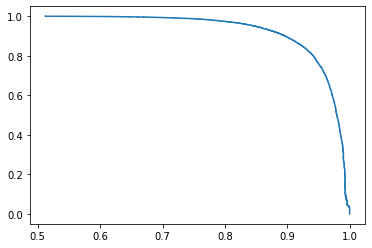

In [36]:
plt.plot(precision, recall)